# data

In [7]:
import pandas as pd
import os.path as osp
import inspect
from torch_geometric.data import Data
from sklearn import preprocessing

import torch
import torch.nn.functional as F 
import random
import numpy as np
import pdb

import matplotlib.pyplot as plt

from importlib import reload


#### deconstruction

In [ ]:
split_sample = 0. 
node_mode = 0 
train_edge = 0.7 
split_by = 'y'
train_y = 0.7 
seed = 0

In [8]:
# https://github.com/maxiaoba/GRAPE/blob/0ea0c59272a977d0184a8fd95178f68211455ef5/uci/uci_data.py#L158
uci_path = osp.abspath('../repos/GRAPE/uci/')
df_np = np.loadtxt(uci_path+'/raw_data/{}/data/data.txt'.format(data_type))
df_y = pd.DataFrame(df_np[:, -1:])
df_X = pd.DataFrame(df_np[:, :-1])
# data = get_data(df_X, df_y, node_mode, train_edge, split_sample, split_by, train_y, seed)


In [11]:
df_X.shape, df_y.shape

((506, 13), (506, 1))

In [12]:
df_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [14]:
# https://github.com/maxiaoba/GRAPE/blob/0ea0c59272a977d0184a8fd95178f68211455ef5/uci/uci_data.py#L52
train_edge_prob = train_edge 
split_sample_ratio = split_sample
train_y_prob = train_y
normalize=True

In [15]:
if len(df_y.shape)==1:
    df_y = df_y.to_numpy()
elif len(df_y.shape)==2:
    df_y = df_y[0].to_numpy()

In [18]:
if normalize:
    x = df_X.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_X = pd.DataFrame(x_scaled)

In [19]:
# https://github.com/maxiaoba/GRAPE/blob/0ea0c59272a977d0184a8fd95178f68211455ef5/uci/uci_data.py#L32
def create_edge(df):
    n_row, n_col = df.shape
    edge_start = []
    edge_end = []
    for x in range(n_row):
        edge_start = edge_start + [x] * n_col # obj
        edge_end = edge_end + list(n_row+np.arange(n_col)) # att    
    edge_start_new = edge_start + edge_end
    edge_end_new = edge_end + edge_start
    return (edge_start_new, edge_end_new)


In [20]:
# https://github.com/maxiaoba/GRAPE/blob/0ea0c59272a977d0184a8fd95178f68211455ef5/uci/uci_data.py#L43
# sample-feature value is the edge attribute for edge in both directions 
def create_edge_attr(df):
    nrow, ncol = df.shape
    edge_attr = []
    for i in range(nrow):
        for j in range(ncol):
            edge_attr.append([float(df.iloc[i,j])])
    edge_attr = edge_attr + edge_attr
    return edge_attr

In [21]:
# https://github.com/maxiaoba/GRAPE/blob/0ea0c59272a977d0184a8fd95178f68211455ef5/uci/uci_data.py#L14
def create_node(df, mode):
    if mode == 0: # onehot feature node, all 1 sample node
        nrow, ncol = df.shape
        feature_ind = np.array(range(ncol))
        feature_node = np.zeros((ncol,ncol))
        feature_node[np.arange(ncol), feature_ind] = 1
        sample_node = [[1]*ncol for i in range(nrow)]
        node = sample_node + feature_node.tolist()
    elif mode == 1: # onehot sample and feature node --> [issample, isfeat1, isfeat2, ...]
        nrow, ncol = df.shape
        feature_ind = np.array(range(ncol))
        feature_node = np.zeros((ncol,ncol+1))
        feature_node[np.arange(ncol), feature_ind+1] = 1
        sample_node = np.zeros((nrow,ncol+1))
        sample_node[:,0] = 1
        node = sample_node.tolist() + feature_node.tolist()
    return node

In [43]:
edge_start, edge_end = create_edge(df_X)
edge_index = torch.tensor([edge_start, edge_end], dtype=int)
edge_attr = torch.tensor(create_edge_attr(df_X), dtype=torch.float)
node_init = create_node(df_X, node_mode) 
x = torch.tensor(node_init, dtype=torch.float)
y = torch.tensor(df_y, dtype=torch.float)

In [53]:
# randomly select 100*known_prob% edges
def get_known_mask(known_prob, edge_num):
    known_mask = (torch.FloatTensor(edge_num, 1).uniform_() < known_prob).view(-1)
    return known_mask

def mask_edge(edge_index,edge_attr,mask,remove_edge):
    edge_index = edge_index.clone().detach()
    edge_attr = edge_attr.clone().detach()
    if remove_edge:
        edge_index = edge_index[:,mask]
        edge_attr = edge_attr[mask]
    else:
        edge_attr[~mask] = 0.
    return edge_index, edge_attr

In [54]:
#set seed to fix known/unknwon edges
torch.manual_seed(seed)
#keep train_edge_prob of all edges
train_edge_mask = get_known_mask(train_edge_prob, int(edge_attr.shape[0]/2))
double_train_edge_mask = torch.cat((train_edge_mask, train_edge_mask), dim=0)

#mask edges based on the generated train_edge_mask
#train_edge_index is known, test_edge_index in unknwon, i.e. missing
train_edge_index, train_edge_attr = mask_edge(edge_index, edge_attr,
                                            double_train_edge_mask, True)
train_labels = train_edge_attr[:int(train_edge_attr.shape[0]/2),0]
test_edge_index, test_edge_attr = mask_edge(edge_index, edge_attr,
                                            ~double_train_edge_mask, True)
test_labels = test_edge_attr[:int(test_edge_attr.shape[0]/2),0]
#mask the y-values during training, i.e. how we split the training and test sets
train_y_mask = get_known_mask(train_y_prob, y.shape[0])
test_y_mask = ~train_y_mask

data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr,
        train_y_mask=train_y_mask, test_y_mask=test_y_mask,
        train_edge_index=train_edge_index,train_edge_attr=train_edge_attr,
        train_edge_mask=train_edge_mask,train_labels=train_labels,
        test_edge_index=test_edge_index,test_edge_attr=test_edge_attr,
        test_edge_mask=~train_edge_mask,test_labels=test_labels, 
        df_X=df_X,df_y=df_y,
        edge_attr_dim=train_edge_attr.shape[-1],
        user_num=df_X.shape[0]
        )

In [68]:
def get_data(df_X, df_y, node_mode, train_edge_prob, split_sample_ratio, split_by, train_y_prob, seed=0, normalize=True):
    if len(df_y.shape)==1:
        df_y = df_y.to_numpy()
    elif len(df_y.shape)==2:
        df_y = df_y[0].to_numpy()

    if normalize:
        x = df_X.values
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df_X = pd.DataFrame(x_scaled)
    edge_start, edge_end = create_edge(df_X)
    edge_index = torch.tensor([edge_start, edge_end], dtype=int)
    edge_attr = torch.tensor(create_edge_attr(df_X), dtype=torch.float)
    node_init = create_node(df_X, node_mode) 
    x = torch.tensor(node_init, dtype=torch.float)
    y = torch.tensor(df_y, dtype=torch.float)
    
    #set seed to fix known/unknwon edges
    torch.manual_seed(seed)
    #keep train_edge_prob of all edges
    train_edge_mask = get_known_mask(train_edge_prob, int(edge_attr.shape[0]/2))
    double_train_edge_mask = torch.cat((train_edge_mask, train_edge_mask), dim=0)

    #mask edges based on the generated train_edge_mask
    #train_edge_index is known, test_edge_index in unknwon, i.e. missing
    train_edge_index, train_edge_attr = mask_edge(edge_index, edge_attr,
                                                double_train_edge_mask, True)
    train_labels = train_edge_attr[:int(train_edge_attr.shape[0]/2),0]
    test_edge_index, test_edge_attr = mask_edge(edge_index, edge_attr,
                                                ~double_train_edge_mask, True)
    test_labels = test_edge_attr[:int(test_edge_attr.shape[0]/2),0]
    #mask the y-values during training, i.e. how we split the training and test sets
    train_y_mask = get_known_mask(train_y_prob, y.shape[0])
    test_y_mask = ~train_y_mask

    data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr,
            train_y_mask=train_y_mask, test_y_mask=test_y_mask,
            train_edge_index=train_edge_index,train_edge_attr=train_edge_attr,
            train_edge_mask=train_edge_mask,train_labels=train_labels,
            test_edge_index=test_edge_index,test_edge_attr=test_edge_attr,
            test_edge_mask=~train_edge_mask,test_labels=test_labels, 
            df_X=df_X,df_y=df_y,
            edge_attr_dim=train_edge_attr.shape[-1],
            user_num=df_X.shape[0]
            )
    return data 

#### process AnnData

In [8]:
from data import preprocess_paul15, preprocess_basic, get_paul15, get_pbmc3k
import svm 

adata = preprocess_paul15(get_paul15(), n_top_genes=100) 

n_train = 1800 
x_train, x_test, y_train, y_test = svm.split_data_cellclass(adata, n_train, target_col='paul15_clusters_ind')
clf = svm.svm_cellclass(x_train, y_train, x_test, y_test, kernel='linear')

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


/home/hbl/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/data.py:132: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['paul15_clusters_ind'] = adata.obs.paul15_clusters.replace(cats.to_list(), range(len(cats)))


SVM test accuracy: 52.365591397849464


In [9]:
import GRAPE.uci.uci_data as uci_data

split_sample = 0. 
node_mode = 0 
train_edge = 0.7 
split_by = 'y'
train_y = 0.7 
seed = 0

data = uci_data.load_data(adata, target_col='paul15_clusters_ind', node_mode=node_mode, train_edge=train_edge, split_sample=split_sample,
                        split_by=split_by, train_y=train_y, seed=seed)

- convert pytorch geometric data object to heterogeneous and shoehorn into HGT pipeline
- https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data.to_heterogeneous

# training and model

In [7]:
import GRAPE.training.gnn_mdi as gnn_mdi
import GRAPE.training.gnn_y as gnn_y

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
from dataclasses import dataclass
import os

In [9]:
@dataclass 
class ArgsGnnModel: 
    aggr: str = 'mean'
    concat_states: bool = False
    dropout: float = 0. 
    edge_dim: int = 64 
    edge_mode: int = 1  # 0: use it as weight; 1: as input to mlp
    gnn_activation: str = 'relu'
    model_types: str = 'EGSAGE_EGSAGE_EGSAGE'
    node_dim: int = 65 
    norm_embs: str = None  # default to be all true
    post_hiddens: str = None  # default to be 1 hidden of node_dim
    embedding_input_dim: int = None  # for gene node embedding input; num of genes used 

@dataclass
class ArgsOptimizer: 
    epochs: int = 1000
    lr: float = 0.001
    opt: str = 'adam'
    opt_decay_rate: float = 0.9
    opt_decay_step: int = 1000
    opt_scheduler: str = None
    weight_decay: float = 0.
@dataclass 
class Args: 
    model: ArgsGnnModel = ArgsGnnModel()
    optimizer: ArgsOptimizer = ArgsOptimizer() 
    auto_known: bool = False
    ce_loss: bool = False 
    concat_states: bool = False
    dropout: float = 0.
    impute_activation: str = 'relu'
    impute_hiddens: str = '64'
    known: float = 0.7
    loss_mode: int = 0 
    mode: str = 'train'  # debug
    node_dim: int = 64
    # norm_label
    save_model: bool = False
    save_prediction: bool = False
    split_sample: float = 0.
    split_test: bool = False 
    split_train: bool = False 
    transfer_dir: str = None
    transfer_extra: str = ''
    valid: float = 0.
    log_path: str = ''

    predict_hiddens: str = ''
    output_activation: str = None 

missing data imputation task

In [7]:
args_mdi = Args(optimizer = ArgsOptimizer(epochs=1000), log_path='paul15_mdi')

log_path = './test/{}/'.format(args_mdi.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, obj = gnn_mdi.train_gnn_mdi(data, args_mdi, log_path, device)
# [Epoch 0] train (loss=0.01963968202471733) test (rms=0.14331020894571264, l1=0.09327643364667892)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  26
train edge num is 76416, test edge num is input 76416, output 32784
[Epoch 0] train (loss=0.01963968202471733) test (rms=0.1433102154443603, l1=0.09327643364667892)
[Epoch 100] train (loss=0.015433638356626034) test (rms=0.12844715584473496, l1=0.06512066721916199)
[Epoch 200] train (loss=0.012119317427277565) test (rms=0.12986685719402435, l1=0.060217875987291336)
[Epoch 300] train (loss=0.011115457862615585) test (rms=0.12795478632830506, l1=0.06418439745903015)
[Epoch 400] train (loss=0.00944636482745409) test (rms=0.12557705659448623, l1=0.05658411607146263)
[Epoch 500] train (loss=0.008054034784436226) test (rms=0.12298768754427793, l1=0.05391056835651398)
[Epoch 600] train (loss=0.007755075115710497) test (rms=0.12250662077800978, l1=0.05595838278532028)
[Epoch 700] train (loss=0.007508228998631239) test (rms=0.12227991419768615, l1=0.05581122264266014)
[Epoch 800] train (loss=0.007181151770055

predict node label task

In [10]:
args_y = Args(optimizer = ArgsOptimizer(epochs=1000), log_path='paul15_y')

log_path = './test/{}/'.format(args_y.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, predict_model, obj = gnn_y.train_gnn_y(data, args_y, log_path, device)
# [Epoch 0] train (loss=88.68339538574219) test (rms=9.668847813570766, l1=8.222831726074219)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  28
all y num is 2730, train num is 1920, test num is 810
[Epoch 0] train (loss=90.67816162109375) test (rms=9.343526678063878, l1=7.794544696807861)
[Epoch 100] train (loss=25.754165649414062) test (rms=5.160085280549059, l1=4.766758441925049)
[Epoch 200] train (loss=25.749988555908203) test (rms=5.158433301672865, l1=4.765067100524902)
[Epoch 300] train (loss=20.40968894958496) test (rms=4.171791104391105, l1=3.7104668617248535)
[Epoch 400] train (loss=7.508203983306885) test (rms=2.3150386793888886, l1=1.772673487663269)
[Epoch 500] train (loss=5.140228748321533) test (rms=1.9371887080014496, l1=1.4625259637832642)
[Epoch 600] train (loss=4.568821430206299) test (rms=1.7622176519101882, l1=1.3162018060684204)
[Epoch 700] train (loss=3.615602493286133) test (rms=1.719464171027174, l1=1.2529981136322021)
[Epoch 800] train (loss=3.4627933502197266) test (rms=1.7010762202001832, l1=1.2490828037261963)
[Ep

In [13]:
obj['curves'].keys()

dict_keys(['train_loss', 'test_rmse', 'test_l1'])

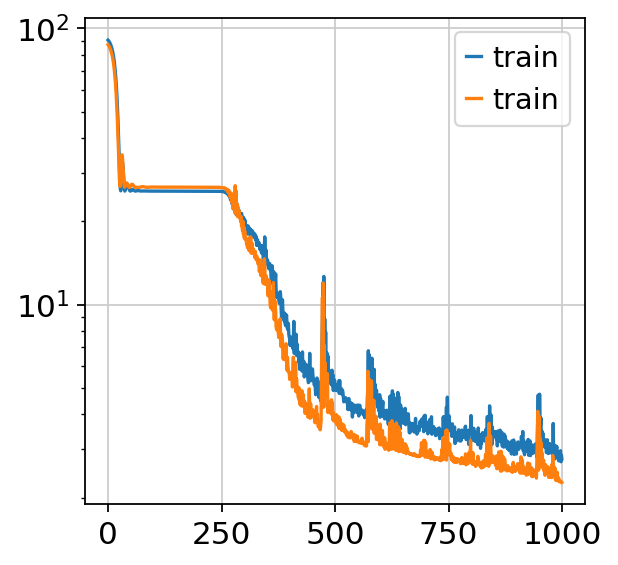

In [15]:
fig, ax = plt.subplots()
ax.plot(obj['curves']['train_loss'], label='train')
ax.plot([i**2 for i in obj['curves']['test_rmse']], label='train')
ax.legend()
ax.set_yscale('log')
fig.show()

predict node label, with one-shot targets (instead of regression)

In [17]:
data_onehot = uci_data.load_data(adata, target_col='paul15_clusters_ind', node_mode=node_mode, train_edge=train_edge, 
    split_sample=split_sample, split_by=split_by, train_y=train_y, seed=seed, one_hot=True)
args_y = Args(optimizer = ArgsOptimizer(epochs=1001), log_path='paul15_y_softmax', output_activation='softmax')

log_path = './test/{}/'.format(args_y.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, predict_model, obj = gnn_y.train_gnn_y(data_onehot, args_y, log_path, device)
# [Epoch 0] train (loss=0.049670442938804626) test (rms=0.2227822332169209, l1=0.09944138675928116)

/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/GRAPE/uci/uci_data.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(df_y, dtype=torch.float)


['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  28
all y num is 2730, train num is 1920, test num is 810
[Epoch 0] train (loss=0.04989926889538765) test (rms=0.22330019506776083, l1=0.09971936792135239)
[Epoch 100] train (loss=0.04838474467396736) test (rms=0.21979458921457065, l1=0.096700519323349)
[Epoch 200] train (loss=0.04838443920016289) test (rms=0.2197896993844335, l1=0.0966934859752655)
[Epoch 300] train (loss=0.04739266261458397) test (rms=0.21695713615074966, l1=0.09484328329563141)
[Epoch 400] train (loss=0.0456494577229023) test (rms=0.21268211442897886, l1=0.09179237484931946)
[Epoch 500] train (loss=0.0413409061729908) test (rms=0.20519742674494512, l1=0.08316276222467422)
[Epoch 600] train (loss=0.039088666439056396) test (rms=0.19979220488366065, l1=0.0794065073132515)
[Epoch 700] train (loss=0.037945907562971115) test (rms=0.20006944374635588, l1=0.0781131237745285)
[Epoch 800] train (loss=0.038079097867012024) test (rms=0.199521321

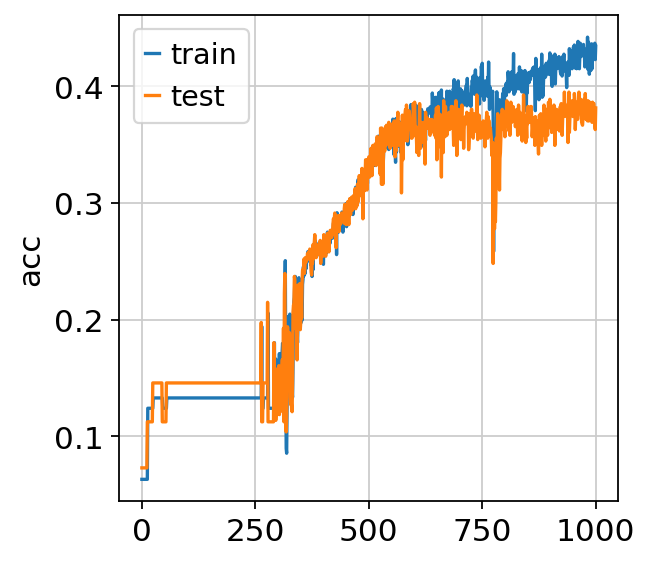

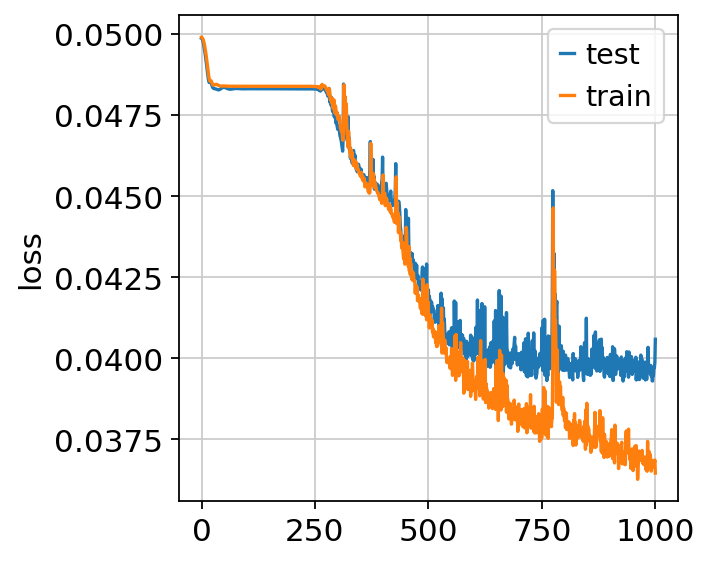

In [18]:
fig, ax = plt.subplots()
ax.plot(obj['curves']['train_acc'], label='train')
ax.plot(obj['curves']['test_acc'], label='test')
ax.set_ylabel('acc')
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.plot([i**2 for i in obj['curves']['test_rmse']], label='test')
ax.plot(obj['curves']['train_loss'], label='train')
ax.set_ylabel('loss')
ax.legend()
fig.show()

try embedding and splitting up node types 

In [72]:
data_1 = uci_data.load_data(adata, target_col='paul15_clusters_ind', node_mode=2, 
        train_edge=train_edge, split_sample=split_sample, split_by=split_by, train_y=train_y, seed=seed,
        one_hot=True)
nrow, ncol = adata.X.shape 

data_het = data_1.to_heterogeneous(
        node_type=torch.tensor([0]*nrow + [1]*ncol), node_type_names=['cell', 'gene'], 
        edge_type=torch.tensor([0]*int(data.num_edges/2) + [1]*int(data.num_edges/2)), 
        edge_type_names=[('cell', 'has-expression', 'gene'), ('gene', 'is-expressed', 'cell')])

emb_dim = 16 
data_het.get_node_store('cell')['x'] = data_het.get_node_store('cell')['x'].repeat(1, emb_dim)

print(data_het.node_types)
print(data_het.edge_types)
print([(t, data_het.get_node_store(t)['x'].shape) for t in data_het.node_types])
print([(t, data_het.get_edge_store(*t)['edge_attr'].shape) for t in data_het.edge_types])
print([(t, data_het.get_edge_store(*t)['edge_index'].shape) for t in data_het.edge_types])

['cell', 'gene']
[('cell', 'has-expression', 'gene'), ('gene', 'is-expressed', 'cell')]
[('cell', torch.Size([2730, 16])), ('gene', torch.Size([100, 1]))]
[(('cell', 'has-expression', 'gene'), torch.Size([273000, 1])), (('gene', 'is-expressed', 'cell'), torch.Size([273000, 1]))]
[(('cell', 'has-expression', 'gene'), torch.Size([2, 273000])), (('gene', 'is-expressed', 'cell'), torch.Size([2, 273000]))]


In [73]:
args_y = Args(model = ArgsGnnModel(embedding_input_dim=ncol), optimizer = ArgsOptimizer(epochs=2001), log_path='paul15_y_softmax_embedgenes', output_activation='softmax')

log_path = './test/{}/'.format(args_y.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, predict_model, obj = gnn_y.train_gnn_y(data_het, args_y, log_path, device)
# [Epoch 0] train (loss=0.04997490346431732) test (rms=0.22347077075299057, l1=0.09978455305099487)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  29
all y num is 2730, train num is 1920, test num is 810
[Epoch 0] train (loss=0.04997489973902702) test (rms=0.22347077075299057, l1=0.09978455305099487)
[Epoch 100] train (loss=0.04838517680764198) test (rms=0.219793529901848, l1=0.09670132398605347)
[Epoch 200] train (loss=0.048384491354227066) test (rms=0.21979036888233577, l1=0.09669464081525803)
[Epoch 300] train (loss=0.046829041093587875) test (rms=0.21619596627633886, l1=0.09419472515583038)
[Epoch 400] train (loss=0.04110142961144447) test (rms=0.2071661959205715, l1=0.08541879057884216)
[Epoch 500] train (loss=0.03892005607485771) test (rms=0.20142902679033173, l1=0.07938467711210251)
[Epoch 600] train (loss=0.03810332342982292) test (rms=0.20001768279881432, l1=0.07814014703035355)
[Epoch 700] train (loss=0.037434279918670654) test (rms=0.20011237682820313, l1=0.0767107754945755)
[Epoch 800] train (loss=0.03668658807873726) test (rms=0.19830

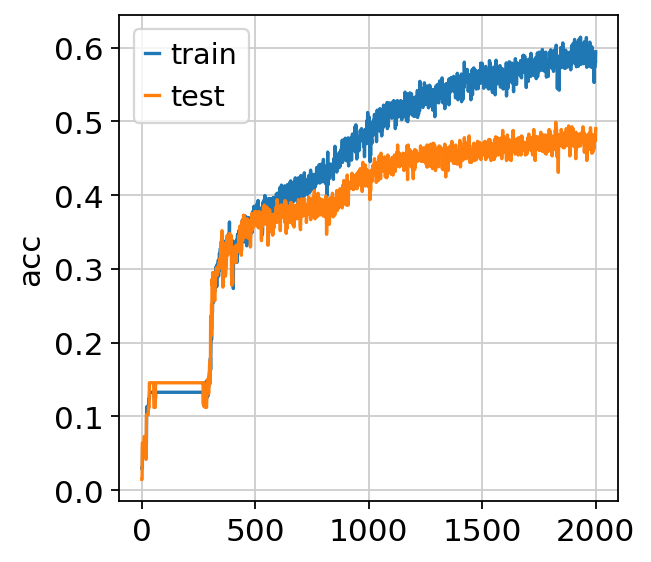

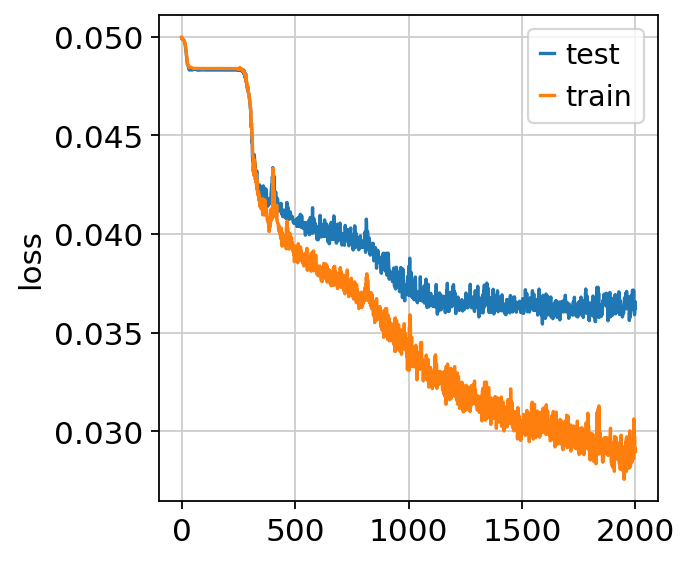

In [74]:
fig, ax = plt.subplots()
ax.plot(obj['curves']['train_acc'], label='train')
ax.plot(obj['curves']['test_acc'], label='test')
ax.set_ylabel('acc')
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.plot(torch.tensor(obj['curves']['test_rmse']).pow(2).tolist(), label='test')
ax.plot(obj['curves']['train_loss'], label='train')
ax.set_ylabel('loss')
ax.legend()
fig.show()

print('final test acc:', (obj['outputs']['pred_test'].argmax(1) == obj['outputs']['label_test'].argmax(1)).mean())

0.4901234567901235

try other hyper params

In [78]:
args_y = Args(model = ArgsGnnModel(embedding_input_dim=ncol), optimizer = ArgsOptimizer(epochs=1001), 
    log_path='paul15_y_softmax_embedgenes_dropout', output_activation='softmax', dropout=0.1)

log_path = './test/{}/'.format(args_y.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, predict_model, obj = gnn_y.train_gnn_y(data_het, args_y, log_path, device)
# [Epoch 0] train (loss=0.04997490346431732) test (rms=0.22347077075299057, l1=0.09978455305099487)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  29
all y num is 2730, train num is 1920, test num is 810
[Epoch 0] train (loss=0.04992092773318291) test (rms=0.2234411626128801, l1=0.09978003054857254)
[Epoch 100] train (loss=0.048388801515102386) test (rms=0.21979321634430282, l1=0.09670284390449524)
[Epoch 200] train (loss=0.0483873076736927) test (rms=0.2197910383781987, l1=0.09670227020978928)
[Epoch 300] train (loss=0.04839150980114937) test (rms=0.21979308922625168, l1=0.09670183062553406)
[Epoch 400] train (loss=0.04838865250349045) test (rms=0.21985124229564265, l1=0.09674450755119324)
[Epoch 500] train (loss=0.042799212038517) test (rms=0.20513530115812526, l1=0.08456213772296906)
[Epoch 600] train (loss=0.04105396568775177) test (rms=0.20262332550277065, l1=0.08216699212789536)
[Epoch 700] train (loss=0.04062182456254959) test (rms=0.20185021041569054, l1=0.08063863217830658)
[Epoch 800] train (loss=0.03983340784907341) test (rms=0.20301013

final test acc: 0.36049382716049383


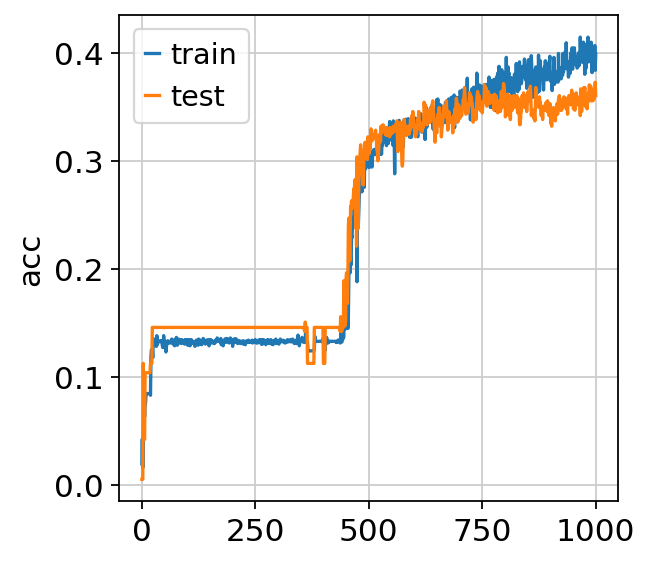

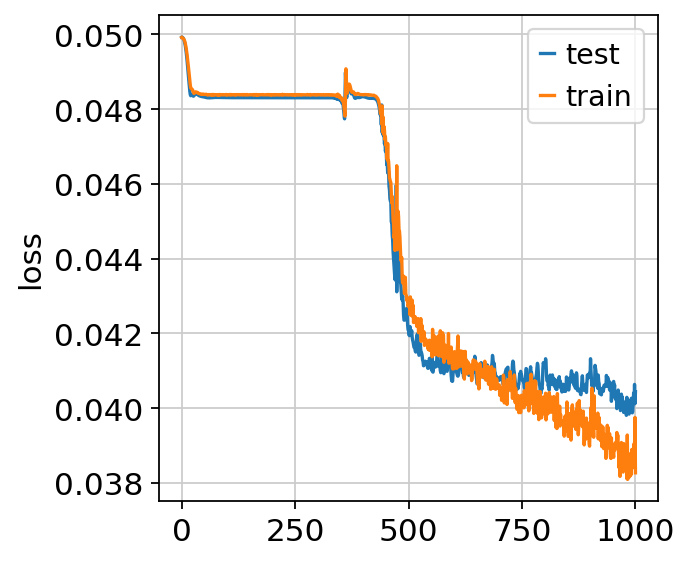

In [80]:
fig, ax = plt.subplots()
ax.plot(obj['curves']['train_acc'], label='train')
ax.plot(obj['curves']['test_acc'], label='test')
ax.set_ylabel('acc')
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.plot(torch.tensor(obj['curves']['test_rmse']).pow(2).tolist(), label='test')
ax.plot(obj['curves']['train_loss'], label='train')
ax.set_ylabel('loss')
ax.legend()
fig.show()

print('final test acc:', (obj['outputs']['pred_test'].argmax(1) == obj['outputs']['label_test'].argmax(1)).mean())

- change node prediction to classification 
- change feature embeddings to learnable parameters 